In [1]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
def plot_series(time, series,start=0, end=None ,format='-', label=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.grid(True)
    

In [3]:
# To create series we need trend, seasonality and noise
#Creating trend
def trend(time, slope=0):
    return time*slope

In [33]:
#Creating seasonality
def seasonal_pattern(season_time):
    return np.where(season_time<0.1, np.cos(season_time*2*np.pi), 1/ np.exp(season_time*3))

#Return the same patter at each period
def seasonality(time, period ,amplitude=1, phase=0):
    season_time=((time+phase) % period)/ period
    return amplitude*seasonal_pattern(season_time)
    


In [34]:
#Adding noise
def noise(time, noise_level=1, seed=None):
    rnd=np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

In [35]:
#Definining parameters
time=np.arange(4* 365 + 1, dtype='float32')

baseline=10
series=trend(time, 0.1)
baseline=10

amplitude=30
slope=0.08
noise_level=15

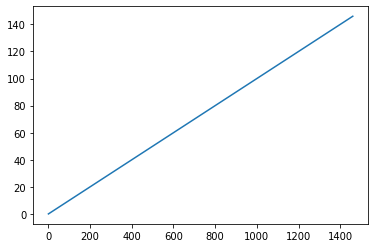

In [7]:
plt.plot(series)

In [36]:
series=baseline+trend(time, slope)+ seasonality(time, period=365, amplitude=amplitude)

In [37]:
series.std()

32.860683

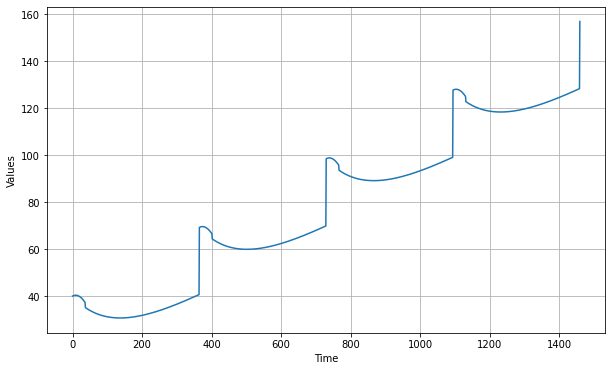

In [38]:
plt.figure(figsize=(10,6))
plot_series(time, series)

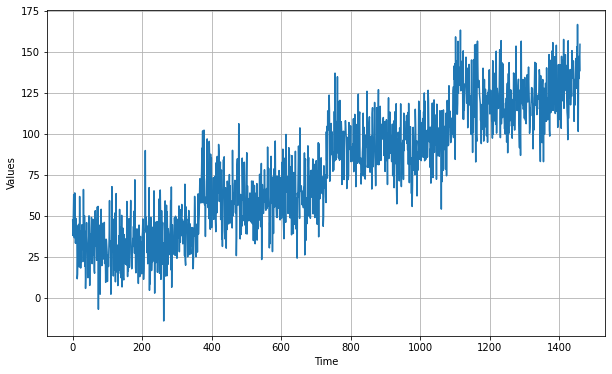

In [39]:
#Adding noise
series+= noise(time, noise_level, seed=42)
plt.figure(figsize=(10,6))
plot_series(time, series)

In [40]:
# Splitting into train and validation sets
split_time=1000
time_valid=time[split_time:]
time_train=time[:split_time]
x_valid=series[split_time:]
x_train=series[:split_time]

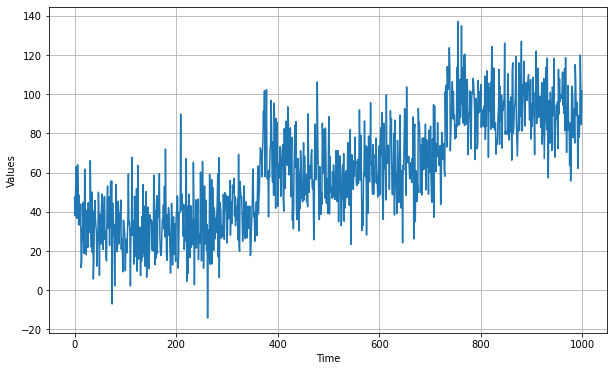

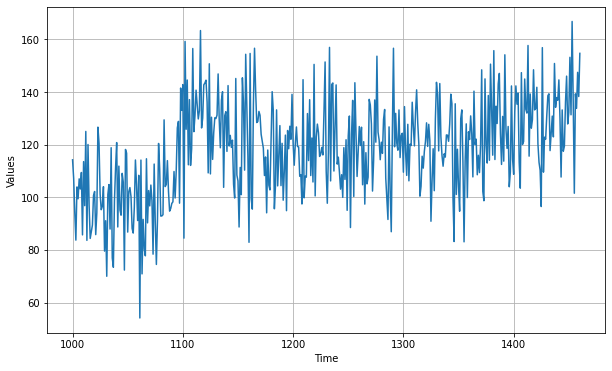

In [41]:
plt.figure(figsize=(10,6))
plot_series(time_train, x_train)

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)

In [42]:
window_size=20
batch_size=32
shuffle_buffer_size=1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset=dataset.flat_map(lambda window: window.batch(window_size+1))
    datset=dataset.shuffle(shuffle_buffer)
    dataset=dataset.map(lambda window: (window[:-1], window[-1]))
    dataset=dataset.batch(batch_size).prefetch(1)
    return dataset

In [16]:
dataset=windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
dataset

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

In [18]:
forecast = []
for time in range(len(series)- window_size):
    forecast.append(model.predict(series[time: time+ window_size][np.newaxis]))

forecast=forecast[split_time - window_size:]

results=np.array(forecast)[:,0,0]


In [19]:
series.std()

39.909607

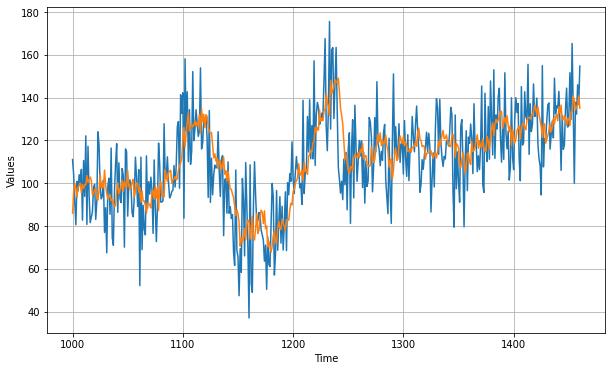

In [20]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.show()

In [21]:
forecast

[array([[86.000046]], dtype=float32),
 array([[96.11932]], dtype=float32),
 array([[99.7714]], dtype=float32),
 array([[97.452]], dtype=float32),
 array([[93.606766]], dtype=float32),
 array([[98.23295]], dtype=float32),
 array([[98.88515]], dtype=float32),
 array([[100.00278]], dtype=float32),
 array([[95.479065]], dtype=float32),
 array([[99.437935]], dtype=float32),
 array([[97.63564]], dtype=float32),
 array([[99.445335]], dtype=float32),
 array([[99.19157]], dtype=float32),
 array([[103.61103]], dtype=float32),
 array([[100.37437]], dtype=float32),
 array([[101.71577]], dtype=float32),
 array([[102.90821]], dtype=float32),
 array([[101.44674]], dtype=float32),
 array([[94.6695]], dtype=float32),
 array([[95.30428]], dtype=float32),
 array([[96.79099]], dtype=float32),
 array([[97.84663]], dtype=float32),
 array([[92.78299]], dtype=float32),
 array([[92.136635]], dtype=float32),
 array([[96.44675]], dtype=float32),
 array([[104.231926]], dtype=float32),
 array([[97.777306]], dtype=

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

13.403493

In [23]:
#Callbacks
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])


lr_schedule=tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 *10**(epoch/window_size))
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history= model.fit(dataset, epochs=100, callbacks= [lr_schedule] , verbose=0)

(1e-08, 0.001, 0.0, 500.0)

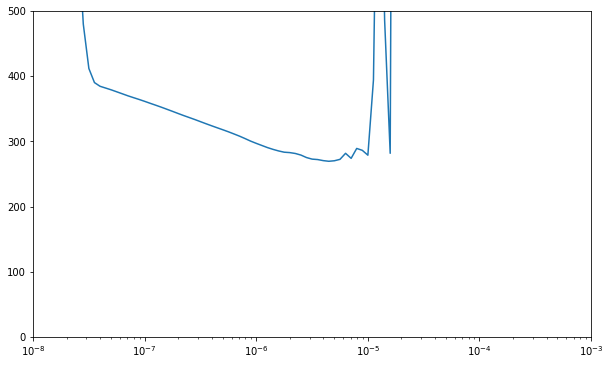

In [25]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10,6))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 500])

In [26]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

In [31]:
forecast = []
for time in range(len(series)- window_size):
    forecast.append(model.predict(series[time: time+ window_size][np.newaxis]))

forecast=forecast[split_time - window_size:]

results=np.array(forecast)[:,0,0]


In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

22.257774